In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler

In [13]:
# Chargement des données
# Assurez-vous que le fichier 'detection_fraud.csv' est dans le bon répertoire
# Ce dataset contient des transactions bancaires avec des indicateurs de fraude

df = pd.read_csv('dataset.csv')

#preparation des donner 
df.columns = ['Month','deaths']
#supression des valaur null 
df = df.dropna()

#verification les types de donner 
print(df.dtypes)

#df 
df = df[:30]


Month      object
deaths    float64
dtype: object


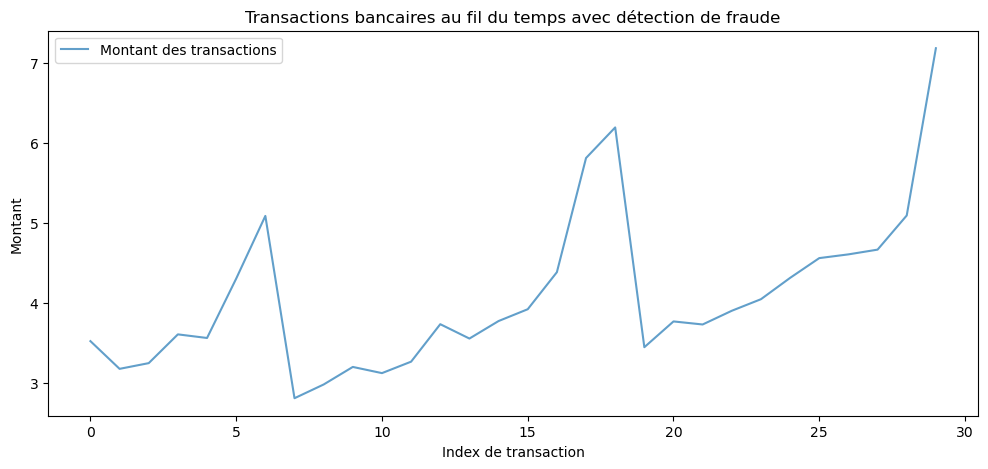

In [14]:
# Visualisation des transactions bancaires avec des indicateurs de fraude
plt.figure(figsize=(12, 5))
plt.plot(df['deaths'], label="Montant des transactions", alpha=0.7)

plt.legend()
plt.title("Transactions bancaires au fil du temps avec détection de fraude")
plt.xlabel("Index de transaction")
plt.ylabel("Montant")
plt.show()

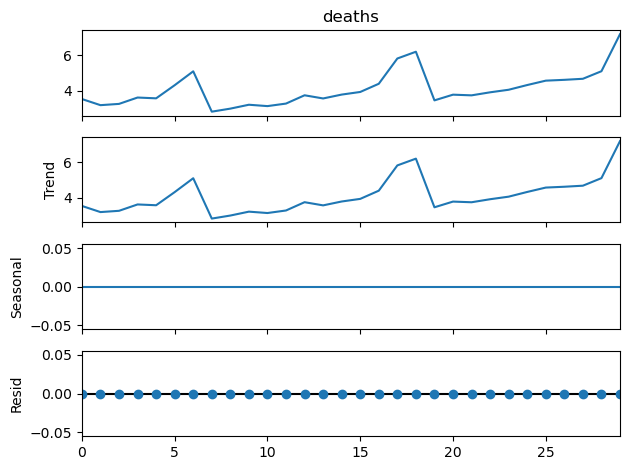

In [15]:
# Décomposition de la série temporelle
# Analyse des composantes saisonnières, tendances et résiduelles
decomposition = seasonal_decompose(df["deaths"], model="additive", period=1)  # Période de 24 heures (hypothèse journalière)
decomposition.plot()
plt.show()

In [9]:
# Test de stationnarité avec le test de Dickey-Fuller
result = adfuller(df["amount"])
print(f"P-value : {result[1]}")  # Si 

P-value : 0.0


p-value < 0.05 donc la série est stationnaire

In [10]:
# Modélisation avec ARIMA
# ARIMA(p,d,q) : Ajustement automatique des paramètres (ici : (2,1,2))
model = ARIMA(df["amount"], order=(2,1,2))  
model_fit = model.fit()

C:\Users\info\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


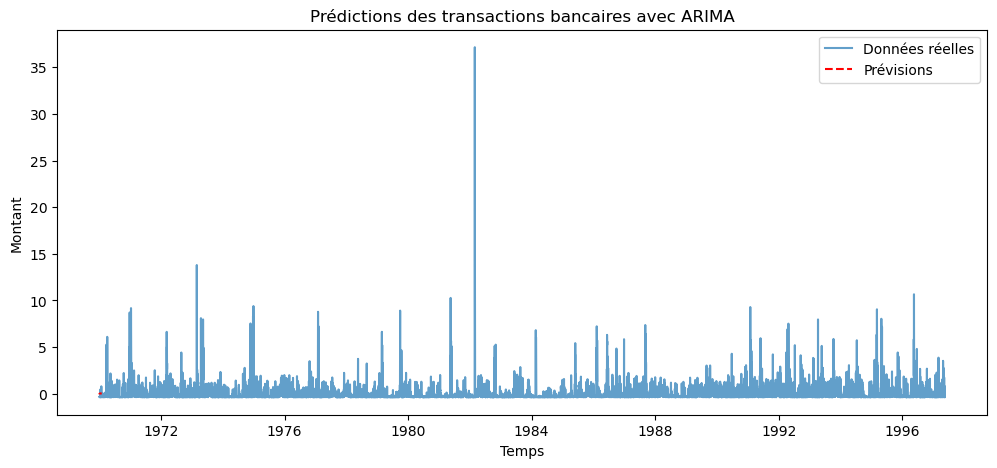

In [11]:
# Prédiction des 30 prochaines valeurs
date_range = pd.date_range(start=df.index[-1], periods=30, freq='D')
forecast = model_fit.forecast(steps=30)

# Visualisation des prévisions
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["amount"], label="Données réelles", alpha=0.7)
plt.plot(date_range, forecast, label="Prévisions", color='red', linestyle='dashed')
plt.legend()
plt.title("Prédictions des transactions bancaires avec ARIMA")
plt.xlabel("Temps")
plt.ylabel("Montant")
plt.show()

In [12]:
# Détection des anomalies
# Calcul de l'erreur entre la réalité et la prédiction
df["erreur"] = abs(df["amount"] - model_fit.fittedvalues)

# Seuil d'anomalie basé sur 3 fois l'écart-type
detection_threshold = 3 * df["erreur"].std()
df["anomalie"] = df["erreur"] > detection_threshold

# Affichage des transactions suspectes
anomalies = df[df["anomalie"] == True]
print(anomalies)

      Unnamed: 0  step  type    amount  oldbalanceOrg  newbalanceOrig  \
85            85     1     1  5.265158           0.00             0.0   
89            89     1     1  4.977601           0.00             0.0   
94            94     1     1  6.088538           0.00             0.0   
132          132     1     1  2.162857         290.00             0.0   
358          358     1     1  5.387483           0.00             0.0   
...          ...   ...   ...       ...            ...             ...   
9664        9664     7     1  2.254519       48039.00             0.0   
9669        9669     7     1  4.792007      125704.00             0.0   
9903        9903     7     1  2.247459       13090.00             0.0   
9925        9925     7     1  3.857701      146609.92             0.0   
9979        9979     7     1  3.515783       14230.40             0.0   

      oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
85          29031.00      5515763.34        0             

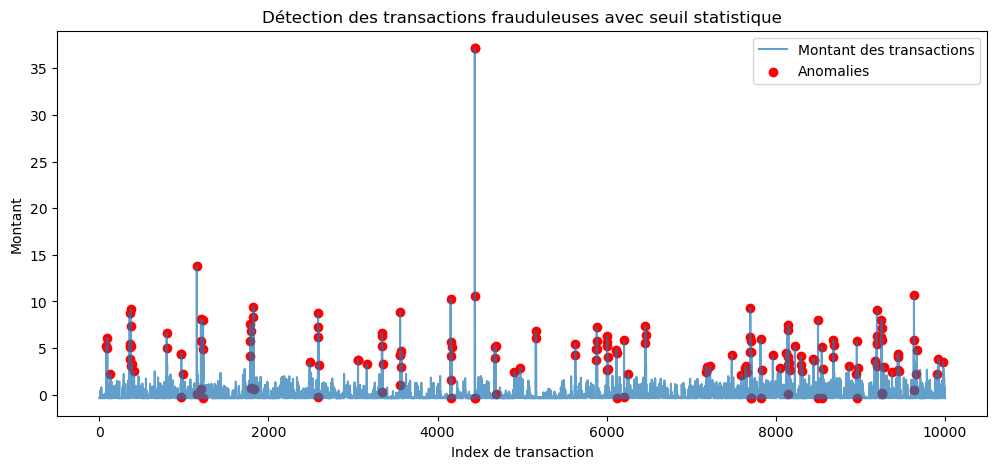

In [13]:
# Visualisation des anomalies
plt.figure(figsize=(12, 5))
plt.plot(df["amount"], label="Montant des transactions", alpha=0.7)
plt.scatter(anomalies.index, anomalies["amount"], color="red", label="Anomalies", marker="o")
plt.legend()
plt.title("Détection des transactions frauduleuses avec seuil statistique")
plt.xlabel("Index de transaction")
plt.ylabel("Montant")
plt.show()

In [14]:
def predict_fraud(new_observation, model_fit, scaler, detection_threshold):
   
    # Convert the new observation into a DataFrame
    new_df = pd.DataFrame([new_observation])

    # Encode the transaction type
    encoding = {'PAYMENT': 0, 'TRANSFER': 1, 'CASH_OUT': 2, 'DEBIT': 3, 'CASH_IN': 4}
    new_df['type'] = new_df['type'].map(encoding)

    # Preprocess the step (convert to hour of the day)
    new_df['step'] = new_df['step'] % 24

    # Normalize the amount using the pre-fitted scaler
    new_df['amount'] = scaler.transform(new_df[['amount']])

    # Predict the amount using the ARIMA model
    predicted_amount = model_fit.forecast(steps=1).iloc[0]

    # Calculate the error (difference between actual and predicted amount)
    error = abs(new_df['amount'].iloc[0] - predicted_amount)

    # Determine if the observation is an anomaly (fraudulent)
    is_fraudulent = error > detection_threshold

    return is_fraudulent

In [15]:
# Example new observation
new_observation = {
    'step': 15,  # Time step
    'type': 'TRANSFER',  # Transaction type
    'amount': 10000,  # Transaction amount
}

# Predict if the new observation is fraudulent
is_fraudulent = predict_fraud(new_observation, model_fit, scaler, detection_threshold)
print(f"Is the transaction fraudulent? {is_fraudulent}")

Is the transaction fraudulent? False


In [16]:
import joblib

# Save the ARIMA model
joblib.dump(model_fit, 'arima_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the detection threshold
joblib.dump(detection_threshold, 'detection_threshold.pkl')

['detection_threshold.pkl']